In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing

c:\Users\ksyuk\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('prices-split-adjusted.csv', parse_dates=True)
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


## Данные: среднеднее между open и close и добавлены выходные дни как среднее. Применяется метод rolling (скользящего окна) с целью сгладить данные. Методы: Хольта, Арима, RandomForestRegressor.

In [38]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

filtered_df = df[df['symbol'] == 'WLTW']
full_date_range = pd.date_range(start=filtered_df.index.min(), end=filtered_df.index.max(), freq='D')

filtered_df = filtered_df.reindex(full_date_range)
filtered_df['average'] = (filtered_df['open'] + filtered_df['close']) / 2

filtered_df['average'] = filtered_df['average'].fillna(method='ffill')
result = filtered_df[['average']].reset_index().rename(columns={'index': 'date'})

result.head()

C:\Users\ksyuk\AppData\Local\Temp\ipykernel_9260\1562838751.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df['average'] = filtered_df['average'].fillna(method='ffill')


,date,average
0,2016-01-05,124.634998
1,2016-01-06,122.610000
2,2016-01-07,115.664997
3,2016-01-08,116.050003
4,2016-01-09,116.050003


In [39]:
result.to_csv('own_data_mean.csv')

In [53]:
data = pd.read_csv('own_data_mean.csv', parse_dates=True)
data = data[['date','average']]
data = data.set_index('date')

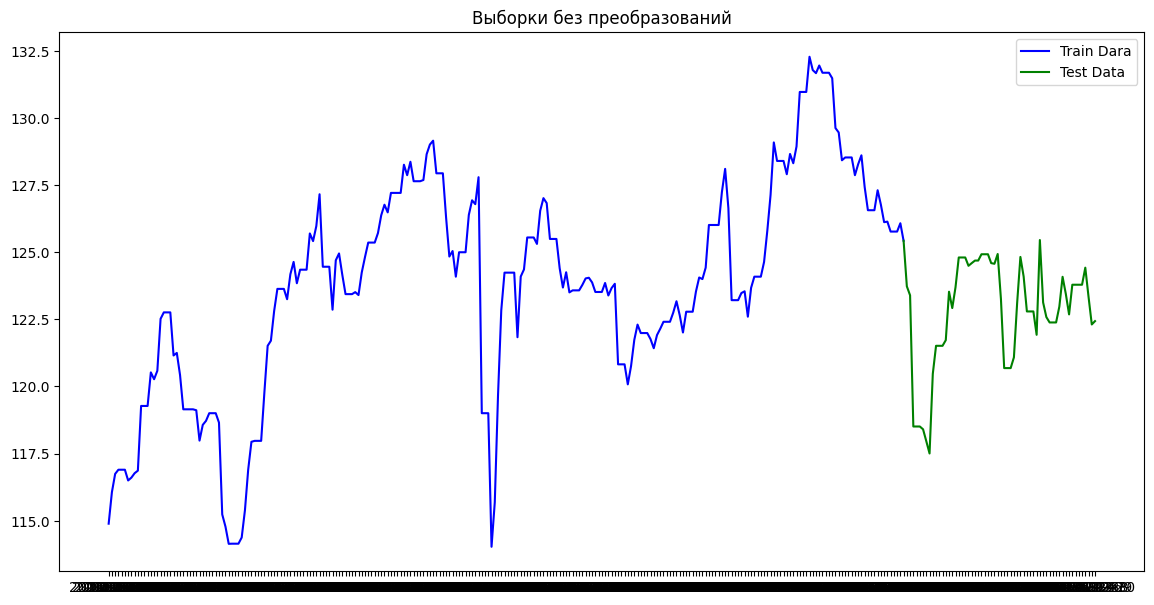

In [60]:
import matplotlib.dates as mdates

start_date = '2016-03-01'
mid_date = '2016-11-01'
data_all = data[data.index >= start_date]
train_f = data_all[data_all.index <= mid_date]
test_f = data_all[data_all.index >= mid_date]


plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f['average'], label='Train Dara', color='b')
plt.plot(test_f.index, test_f['average'], label='Test Data', color='g')
plt.title('Выборки без преобразований')
plt.legend()
plt.show()

In [61]:
adf_test = adfuller(data_all)
print(f'p-value = {adf_test[1]}')
if adf_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 0.019291653343916228
Ряд стационарен


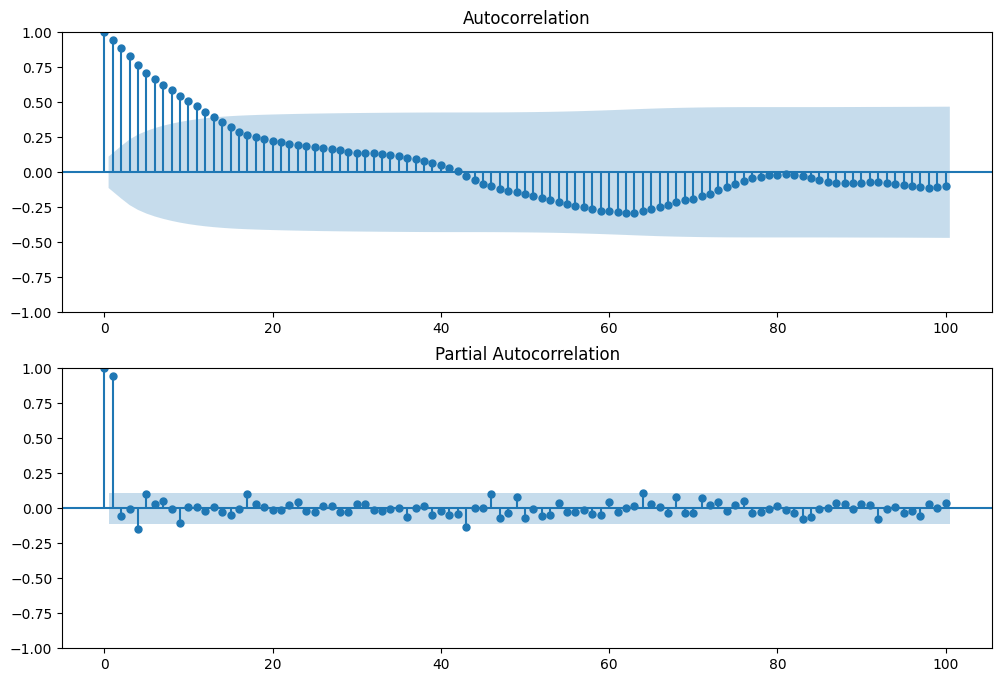

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(data_all, ax=ax1, lags=100)
sm.graphics.tsa.plot_pacf(data_all, ax=ax2, lags=100)
plt.show()

C:\Users\ksyuk\AppData\Local\Temp\ipykernel_9260\2955674978.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_win = data_all['average'].rolling(window=window_size).mean().fillna(method='bfill')


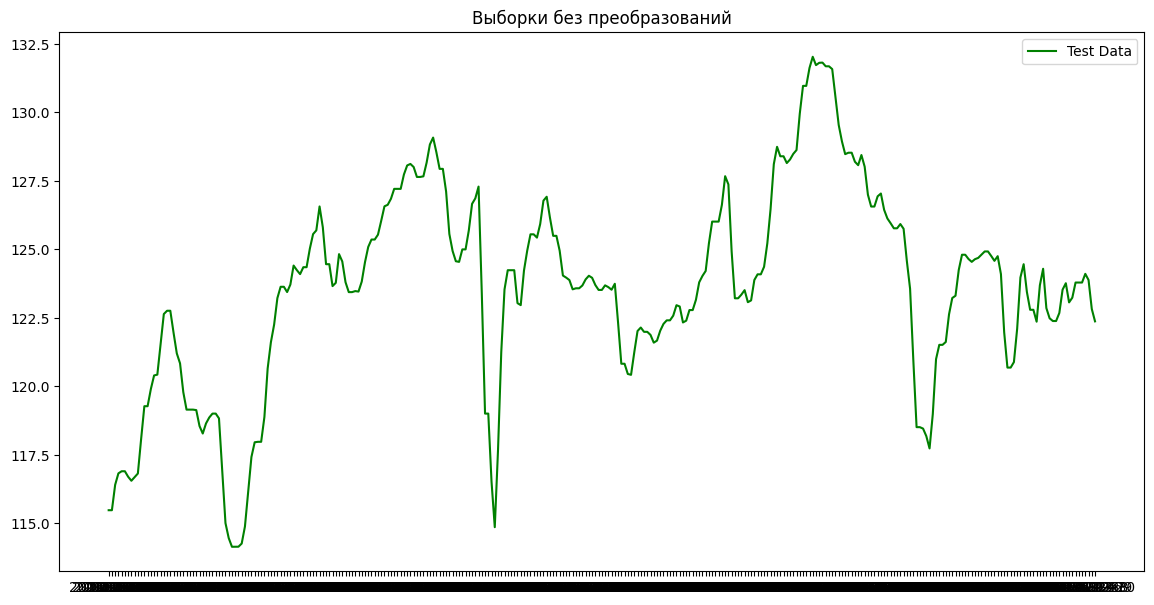

In [79]:
window_size = 2
data_win = data_all['average'].rolling(window=window_size).mean().fillna(method='bfill')
plt.figure(figsize=(14, 7))
#plt.plot(train_f.index, train_f['average'], label='Train Dara', color='b')
plt.plot(data_win, label='Test Data', color='g')
plt.title('Выборки без преобразований')
plt.legend()
plt.show()

In [80]:
adf_test = adfuller(data_win)
print(f'p-value = {adf_test[1]}')
if adf_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 0.029282276846282804
Ряд стационарен


In [81]:
start_date = '2016-03-01'
mid_date = '2016-11-01'
train_f_win = data_win[data_win.index <= mid_date]
test_f_win = data_win[data_win.index >= mid_date]

# Метод Хольта

In [87]:
model_holt = ExponentialSmoothing(train_f_win, damped_trend=True, trend='add', 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=31).fit()

forecast_holt_fix = model_holt.forecast(steps=len(test_f_win))


# initial_value = train_f.iloc[-1].values[0]  # Преобразование последнего значения в скаляр
# forecast_holt = initial_value + forecast_holt_diff_2.reset_index(drop=True)

print(f'Final Forecast Holt:\n{forecast_holt_fix}')

Final Forecast Holt:
2016-11-02    125.662892
2016-11-03    125.653273
2016-11-04    125.589312
2016-11-05    125.337295
2016-11-06    124.852413
2016-11-07    124.661936
2016-11-08    124.440674
2016-11-09    123.953012
2016-11-10    123.570419
2016-11-11    123.099270
2016-11-12    122.929333
2016-11-13    122.941406
2016-11-14    123.058786
2016-11-15    122.996496
2016-11-16    122.758304
2016-11-17    122.800235
2016-11-18    122.859768
2016-11-19    122.839878
2016-11-20    122.940282
2016-11-21    123.224554
2016-11-22    123.669774
2016-11-23    124.091559
2016-11-24    124.239351
2016-11-25    124.270101
2016-11-26    123.683977
2016-11-27    123.000863
2016-11-28    122.929721
2016-11-29    122.640163
2016-11-30    122.563082
2016-12-01    123.102493
2016-12-02    123.560226
2016-12-03    123.909073
2016-12-04    124.250218
2016-12-05    124.466868
2016-12-06    124.439340
2016-12-07    124.134048
2016-12-08    124.087244
2016-12-09    123.980921
2016-12-10    123.585209
2016

C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


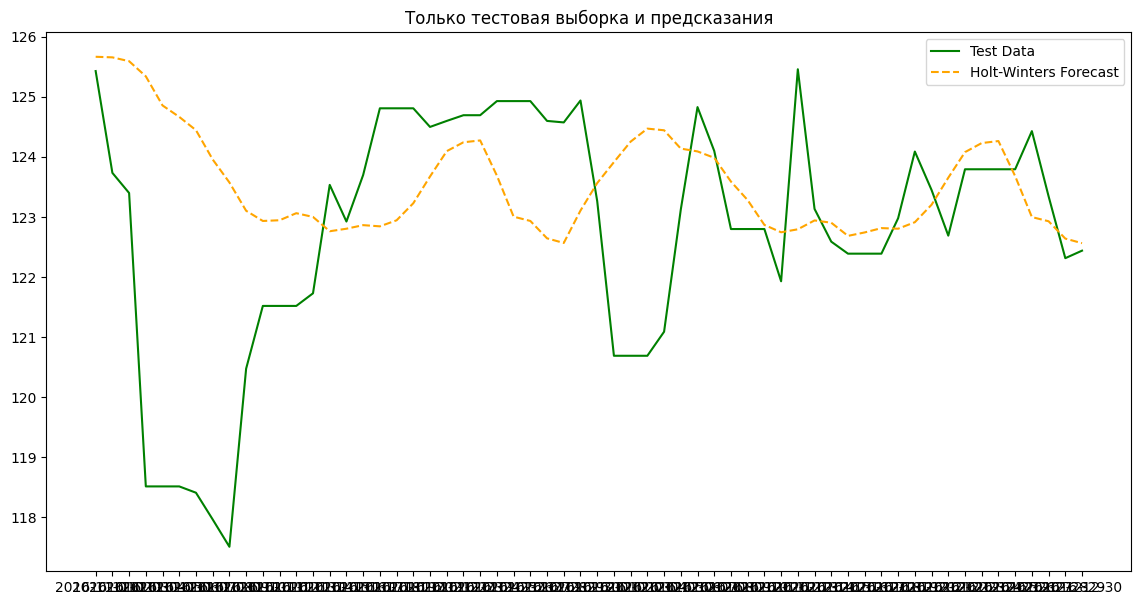

In [88]:
plt.figure(figsize=(14, 7))
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt_fix, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title('Только тестовая выборка и предсказания')
plt.show()

In [89]:
print(mean_absolute_error(test_f_win, forecast_holt_fix))

1.559112273910032


In [98]:
from sklearn.metrics import mean_absolute_error, accuracy_score

def get_behavior(series):
    return (series.diff() > 0).astype(int)  # 1 для повышения, 0 для понижения


test_b = get_behavior(test_f_win)
forc_b = get_behavior(forecast_holt_fix)

accuracy = accuracy_score(test_b, forc_b)
print(f'Accuracy of behavior prediction: {accuracy:.2f}')

Accuracy of behavior prediction: 0.58


In [ ]:
import neptune
import optuna


run = neptune.init_run(
    project="delakoka/TimesSeries",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDNhNjVjYi1jZjU1LTQ5MjItODM0Zi03ZDQyNzhhZGQ2ODYifQ==",
)

def objective(trial):
    trend = trial.suggest_categorical('trend', ['add', None])
    
    if trend is not None:
        damped_trend = trial.suggest_categorical('damped_trend', [True, False])
    else:
        damped_trend = False
    
    seasonal = trial.suggest_categorical('seasonal', ['add', None])
    seasonal_periods = trial.suggest_int('seasonal_periods', 2, 48)

    # Обучение модели
    model = ExponentialSmoothing(train_f_win,
                                 damped_trend=damped_trend, 
                                 trend=trend,
                                 seasonal=seasonal,
                                 seasonal_periods=seasonal_periods,
                                 initialization_method='estimated')
    
    try:
        model_fit = model.fit()
        forecast_holt = model_fit.forecast(steps=len(test_f_win))
        
        mae = mean_absolute_error(test_f_win, forecast_holt)
        
        run['trial/mae'].log(mae)
        run['trial/params'].log(trial.params)
        
    except Exception as e:
        run['trial/exception'].log(str(e))
        mae = float('inf')
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

run['best_params'] = study.best_params
run['best_value'] = study.best_value

print(f"Best parameters: {study.best_params}")
print(f"Best MAE: {study.best_value}")

# ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


def objective(trial):
    p = trial.suggest_int('p', 0, 20)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 20)
    
    # Создание и обучение модели ARIMA
    model = ARIMA(train_f_win, order=(p, d, q))
    try:
        model_fit = model.fit()
    except ValueError as e:
        return float("inf")  # Возвращаем бесконечное значение при ошибке

    # Прогнозирование
    forecast_arima = model_fit.get_forecast(steps=len(test_f_win)).predicted_mean
    
    # Оценка модели
    mae = mean_absolute_error(test_f_win, forecast_arima)
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Parameters:", best_params)

C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\b

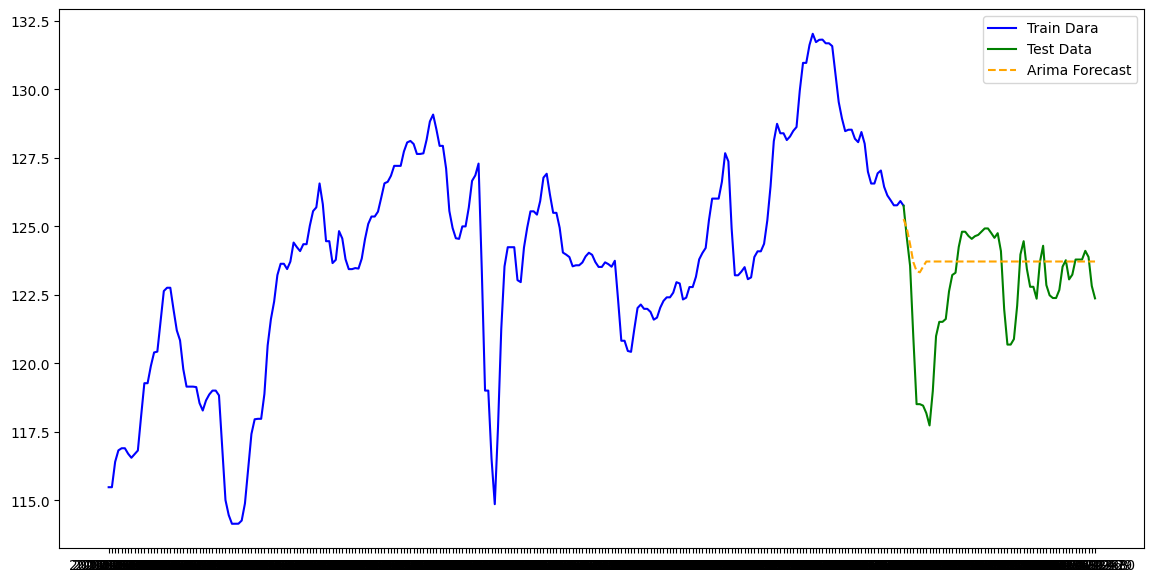

In [102]:
model = ARIMA(train_f_win, order=(0,0,7))
model_fit = model.fit()

forecast_arima = model_fit.get_forecast(steps=len(test_f_win)).predicted_mean

plt.figure(figsize=(14, 7))
plt.plot(train_f_win.index, train_f_win, label='Train Dara', color='b')
plt.plot(test_f_win.index, test_f_win, label='Test Data', color='g')
plt.plot(test_f_win.index, forecast_arima, label='Arima Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

In [103]:
test_b = get_behavior(test_f_win)
forc_b = get_behavior(forecast_arima)

accuracy = accuracy_score(test_b, forc_b)
print(f'Accuracy of behavior prediction: {accuracy:.2f}')

Accuracy of behavior prediction: 0.53


# RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train = np.arange(len(train_f_win)).reshape(-1, 1)  # Простое временное представление
y_train = train_f_win
X_test = np.arange(len(train_f_win), len(train_f_win) + len(test_f_win)).reshape(-1, 1)
y_test = test_f_win

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 3, 60)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    # Создание и обучение модели RandomForestRegressor
    model_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    model_rf.fit(X_train, y_train)
    
    # Прогнозирование
    forecast_rf = model_rf.predict(X_test)
    
    # Оценка модели
    mae = mean_absolute_error(y_test, forecast_rf)
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best Parameters:", best_params)

In [120]:
from sklearn.ensemble import RandomForestRegressor

X_train = np.arange(len(train_f_win)).reshape(-1, 1)  # Простое временное представление
y_train = train_f_win
X_test = np.arange(len(train_f_win), len(train_f_win) + len(test_f_win)).reshape(-1, 1)
y_test = test_f_win

# Обучаем модель RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=258, max_depth=40, min_samples_leaf=2, random_state=42)
model_rf.fit(X_train, y_train)

# Прогнозируем
y_pred = model_rf.predict(X_test)

In [121]:
mae = mean_absolute_error(test_f_win, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 3.0151225998008453


In [122]:
test_b = get_behavior(test_f_win)
forc_b = get_behavior(pd.Series(y_pred))

accuracy = accuracy_score(test_b, forc_b)
print(f'Accuracy of behavior prediction: {accuracy:.2f}')

Accuracy of behavior prediction: 0.57


# <strong>Итог работы с непреобразованным рядом</strong>:
## <strong>Метод Хольта</strong>: MAE 1.56, Accuracy of behavior 0.58
## <strong>ARIMA</strong>: MAE 1.45, Accuracy of behavior 0.53
## <strong>RandomForestRegressor</strong>: MAE 3.01, Accuracy of behavior 0.57
### =======================================================================================================================================================================

## Данные: таблица с часами и выходными с последовательно идущими значениями open close
## Метод Хольта на один раз дифференцированном ряду

In [3]:
data = pd.read_csv('own_data.csv', parse_dates=True, index_col = 'date')
data.head()

,numb
date,
2016-01-05 08:00:00,123.430000
2016-01-05 16:00:00,125.839996
2016-01-06 08:00:00,125.239998
2016-01-06 16:00:00,119.980003
2016-01-07 08:00:00,116.379997


In [4]:
data.isnull().sum()

numb    0
dtype: int64

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
numb,722.0,121.901676,5.41845,105.629997,118.662503,123.220001,125.435001,132.770004


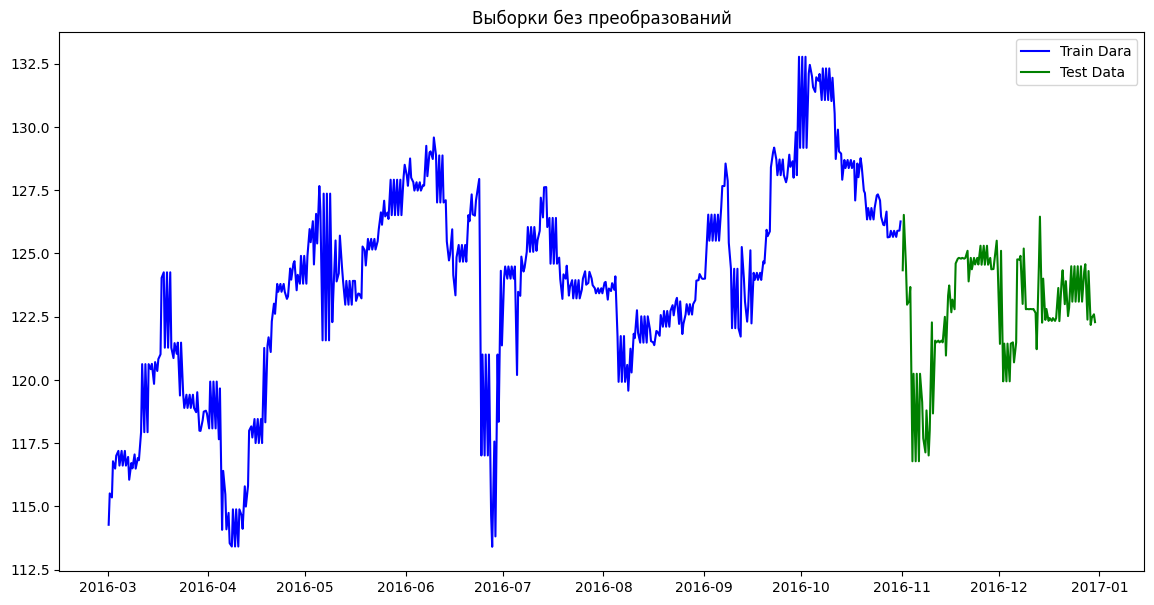

In [6]:
start_date = '2016-03-01'
mid_date = '2016-11-01'
data_all = data[data.index >= start_date]
train_f = data_all[data_all.index < mid_date]
test_f = data_all[data_all.index >= mid_date]


plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f, label='Train Dara', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.title('Выборки без преобразований')
plt.legend()
plt.show()

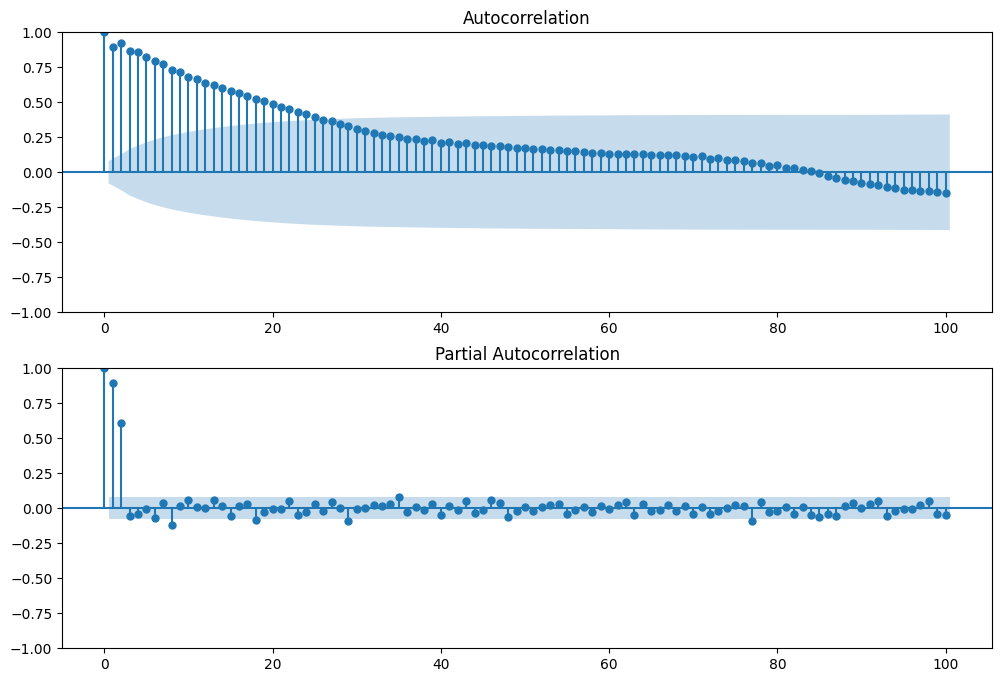

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(data_all, ax=ax1, lags=100)
sm.graphics.tsa.plot_pacf(data_all, ax=ax2, lags=100)
plt.show()

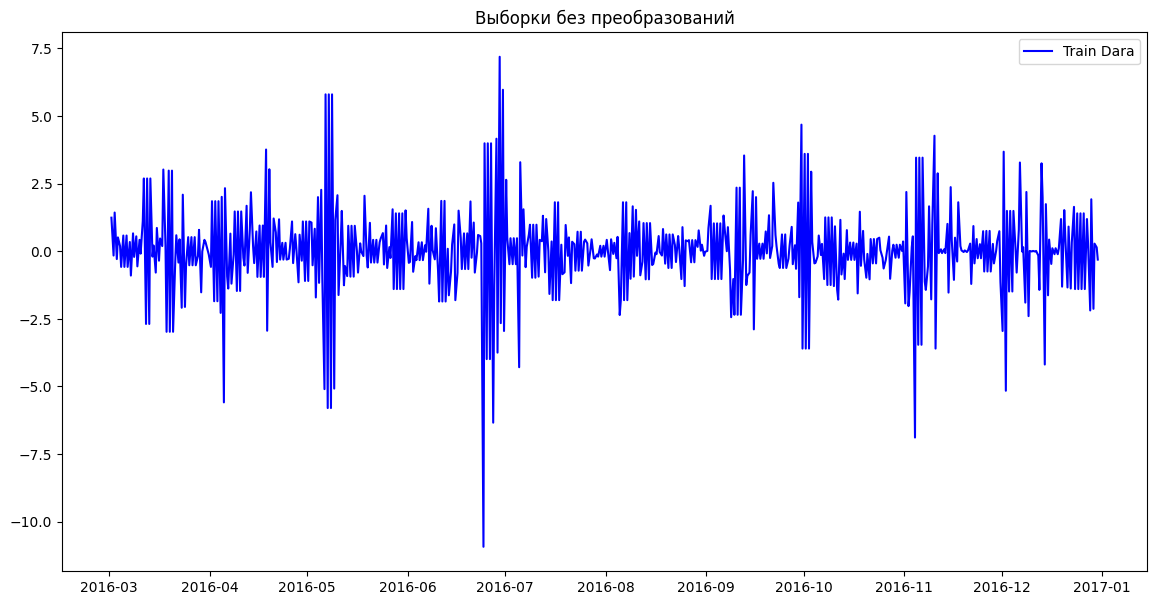

In [7]:
data_fix = data_all.diff().dropna()

plt.figure(figsize=(14, 7))
plt.plot(data_fix.index, data_fix, label='Train Dara', color='b')
#plt.plot(.index, test_f, label='Test Data', color='g')
plt.title('Выборки без преобразований')
plt.legend()
plt.show()

In [8]:
train_fix = data_fix[data_fix.index < mid_date]
test_fix = data_fix[data_fix.index >= mid_date]

In [9]:
train_fix

,numb
date,
2016-03-01 16:00:00,1.240005
2016-03-02 08:00:00,-0.160004
2016-03-02 16:00:00,1.430001
2016-03-03 08:00:00,-0.290001
2016-03-03 16:00:00,0.510002
...,...
2016-10-29 16:00:00,0.239997
2016-10-30 08:00:00,-0.239997
2016-10-30 16:00:00,0.239997


In [10]:
adf_test = adfuller(data_fix)
print(f'p-value = {adf_test[1]}')
if adf_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 7.269474265756933e-14
Ряд стационарен


## Метод Хольта

In [67]:
model_holt = ExponentialSmoothing(train_fix, damped_trend=False, trend=None, 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=22).fit()

forecast_holt_fix = model_holt.forecast(steps=len(test_f))

forecast_holt = train_f.iloc[-1].values[0] + forecast_holt_fix.cumsum()

# initial_value = train_f.iloc[-1].values[0]  # Преобразование последнего значения в скаляр
# forecast_holt = initial_value + forecast_holt_diff_2.reset_index(drop=True)

print(f'Final Forecast Holt:\n{forecast_holt}')

Final Forecast Holt:
489    126.027735
490    125.850467
491    126.499125
492    125.661422
493    125.542773
          ...    
604    128.312472
605    128.231049
606    128.167873
607    128.543349
608    128.360617
Length: 120, dtype: float64


C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [54]:
forecast_holt

489    126.027735
490    125.850467
491    126.499125
492    125.661422
493    125.542773
          ...    
604    128.312472
605    128.231049
606    128.167873
607    128.543349
608    128.360617
Length: 120, dtype: float64

In [55]:
mae_holt = mean_absolute_error(test_f, forecast_holt)
print(f'Holt-Winters MAE: {mae_holt}')

Holt-Winters MAE: 4.414805499614272


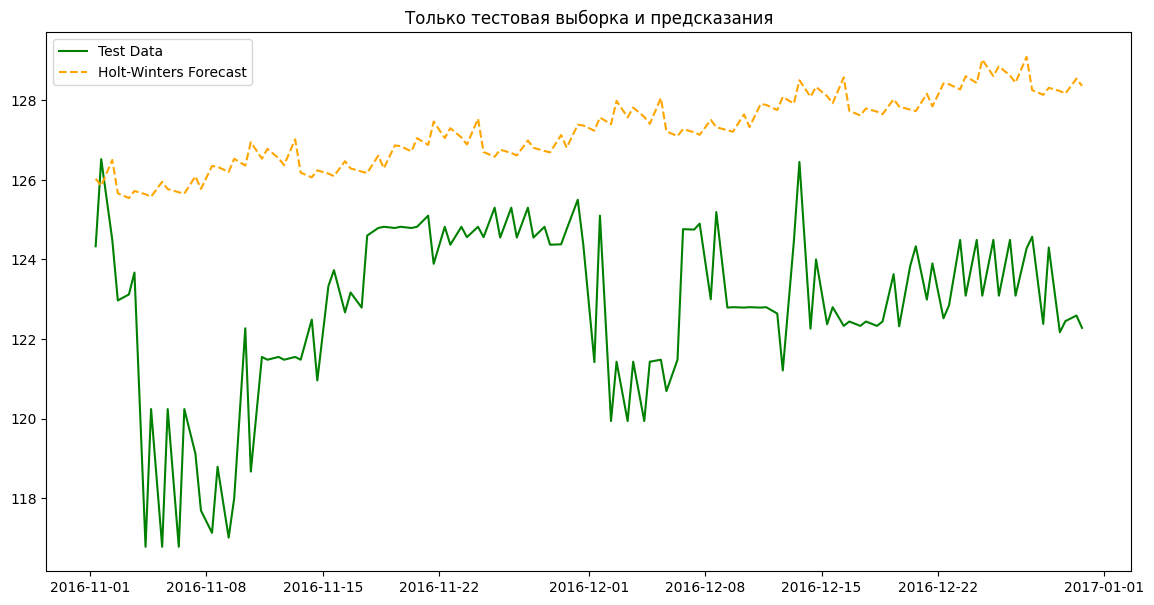

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title('Только тестовая выборка и предсказания')
plt.show()